In [1]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit,compile, execute,IBMQ
from qiskit import BasicAer
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from math import pi
from qiskit.mapper._layout import Layout as Ibmlayout
from qiskit.tools.compiler import compile as qcompile
import matplotlib.pyplot as plt
import sys
from qiskit.tools.visualization import circuit_drawer
from parseRealization import *
from copy import deepcopy
%matplotlib inline
testDir="./tests/"

C:\Users\krylo\Anaconda3\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
#select a backend
IBMQ.load_accounts()
backends = IBMQ.backends(simulator=False,filters=lambda x: x.configuration().n_qubits > 4)
print(backends)
#print(available)
#least_busy = BasicAer.get_backend('qasm_simulator')
least_busy = IBMQ.get_backend('ibmqx4')
couplingMap = least_busy.configuration().coupling_map
print(couplingMap,"its length:",len(couplingMap))
least_busy = IBMQ.get_backend('ibmq_16_melbourne')
couplingMap = least_busy.configuration().coupling_map
print(couplingMap,"its length:",len(couplingMap))
qubitsSize = least_busy.configuration().n_qubits


ConnectionError: Couldn't connect to IBMQ server: error during login: License required. You need to accept the License from Web Platform. https://quantumexperience.ng.bluemix.net

In [3]:
def prepareIBMQLayout(qReg,layout):
    ibmLayout = {}
    for elem in layout:
       # print("Element in layout is",elem," physical is",layout[elem])
        quantum = ord(elem)-ord("a")
        physical = ord(layout[elem])-ord("a")
        quantumTuple = (qReg.name, quantum)
        ibmLayout[quantumTuple]=(qReg.name,physical)
    #print("tempDictionary",ibmLayout)
    #print("items are",ibmLayout.items())
    #print("IBMLAYOUT")
    #print(ibmLayout)
    return ibmLayout

def bigFunction(fileName):
    ioClass = readCircuitInformation(fileName) 
    answers = ioClass.getKmap()

    ioClass.readGatesFromFile(fileName)
    size = ioClass.getSize()
    backend_sim = BasicAer.get_backend('qasm_simulator')
    error_count = 0
    
    ctg = CircuitTransitionGraph()
    tempStuff = ctg.transformCoupling(couplingMap)
    print(tempStuff,len(tempStuff))
    ctg.setSize(size)
   
    leastCost = 2000000
    defaultIBMCost = 100000
    finalAnswer = []
    finalLayout = []
    costHistory =[]
    ibmCostHistory = []
    for i in range(0,1):
        epoch = 0
        #This part corresponds for part of experiment without minimal or no changes
        while epoch < 10:
            print("Epoch number:",epoch)
            print("Current layout of ctg is:",ctg.layout)
            tempLayout = ctg.layout.copy()
            qr,cr,qc = ioClass.createCircuitAndSetInput(i)
            ibmLayout = prepareIBMQLayout(qr,tempLayout)
            qc,qr = ctg.readGatesFromIOClass(qr,qc, ioClass)
            if epoch==0:
                defaultIBMCost = measureFidelityWithoutChanges(qr,cr,qc)
            ctg = fixTheStuff(ctg)
            #This one needs to comply with changes you did
            #qc,qr = ctg.readFixedGatesFromCtg(qr,qc)
           
            qr,cr,qc = ioClass.createCircuitAndSetInput(i)
            qc,qr = ctg.readFixedGatesFromCtg(qr,qc)
            ibmLayout = prepareIBMQLayout(qr,tempLayout)
            tempCost = compileToSeeCost(qr,cr,qc,ioClass,ibmLayout,i)
            ibmCostHistory.append(tempCost)
            costHistory.append(len(ctg.lines))
            if tempCost < leastCost:
                finalAnswer = deepcopy(ctg.lines)
                finalLayout = deepcopy(tempLayout)
                leastCost = tempCost
            #measureToVerifyOutputWtihChanges(qr,cr,qc,ioClass,ibmLayout,i)
            ctg.layOutQubits()
            epoch = epoch+1
    for i in range(0,len(costHistory)):
        for j in range(0,len(costHistory)):
            if costHistory[i] < costHistory[j]:
                tempI = ibmCostHistory[j]
                temp = costHistory[j]
                costHistory[j]=costHistory[i]
                ibmCostHistory[j]=ibmCostHistory[i]
                costHistory[i] = temp
                ibmCostHistory[i] = tempI
    print("Default IBM cost is:",defaultIBMCost)
    print("FinalAnswer is:", finalAnswer)
    print("FinalAnswer finalLayout:", finalLayout)
    print("FinalAnswer cost is:",leastCost)
    print("CostHistory is:",costHistory)
    print("IBMCostHistory is:",ibmCostHistory)   
   
    plt.plot(ibmCostHistory,costHistory)

    
def fixTheStuff(ctg):
    print("Missing connections are",ctg.getMissingConnections())
    #This one to fix the changes... fixthemissingedges connects stuff around. did not test though
    ctg.fixMissingEdges()
    #print("FIxing the stuff")
    return ctg


def  compileToSeeCost(qr,cr,qc,ioClass,ibmLayout,i):
    #least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    qobj = qcompile(qc,least_busy,initial_layout=ibmLayout,pass_manager=None)
    #This line provides print of the compiled circuit qasm
    print("Length of IBM compiled circuit with fixes is:",len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"]))
    return len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"])
    #job = execute(qc,least_busy,shots=200)
    #result = job.result()
    #print(result.get_counts())
    #plot_histogram(result.get_counts())
    
def measureFidelityWithoutChanges(qr,cr,qc):
    #least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    
    qobj = qcompile(qc,least_busy,initial_layout=None,pass_manager=None)
    #This line provides print of the compiled circuit qasm
    print("Length of IBM compiled circuit is:",len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"]))
    return len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"])
#This needs to be implemented    
def measureToVerifyOutputWtihChanges(qr,cr,qc,ioClass,ibmLayout,i):
    least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    job = execute(qc,least_busy,initial_layout=ibmLayout,shots=300)
    result = job.result()
    print(result.get_counts())
    error = ioClass.checkOutputs(result.get_counts(),i)
    if error != 0 :
        print("ERROR APPEARED")
        raise SystemError
    #plot_histogram(result.get_counts())


./tests/sym6_63.pla
The constants are set to .constants ------00000010

The circuit has garbage lines in it or file parsed incorrectly, check ioclass
The circuit has constant inputs in it or file parsed incorrectly, check ioclass
['ab', 'bc', 'cd', 'de', 'ek', 'ef', 'fg', 'fj', 'gi', 'hi', 'ij', 'jk', 'dl', 'kl', 'lm', 'cm', 'bn', 'mn'] 18
Epoch number: 0
Current layout of ctg is: {'a': 'a', 'b': 'b', 'c': 'c', 'd': 'd', 'e': 'e', 'f': 'f', 'g': 'g', 'h': 'h', 'i': 'i', 'j': 'j', 'k': 'k', 'l': 'l', 'm': 'm', 'n': 'n'}
Length of IBM compiled circuit is: 72101
Self skeleton is ['ag', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'fg', 'ef', 'fg', 'fg', 'ef', 'fg', 'fg', 'ef', 'de', 'cd', 'bc', 'ab', 'fg', 'fg', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'gh', 'gh', 'fg', 'gh', 'gh', 'fg', 'gh', 'gh', 'fg', 'ef', 'de', 'cd', 'bc', 'ab', 'fg', 'hi', 'gh', 'ef', 'fg', 'gh', 'hi', 'hi', 'gh', 'hi', 'hi', 'gh', 'hi', 'hi', 'gh', 'fg', 'ef', 'gh', 'ef', 'fg', 'gh', 'hi', 'hi', 'gh', 'hi', 'hi', 'gh', 'hi', 'h

Length of IBM compiled circuit with fixes is: 929467
Initial self.qubitconnectionscount is [('n', 4), ('m', 20), ('a', 138), ('b', 330), ('c', 434), ('d', 452), ('l', 507), ('e', 841), ('k', 1189), ('f', 1370), ('j', 1401), ('g', 1452), ('i', 1579), ('h', 1581)]
wiggle wiggle
Self.qubitconnectionscount is [('n', 4), ('m', 20), ('a', 138), ('b', 330), ('c', 434), ('d', 452), ('l', 507), ('e', 841), ('k', 1189), ('f', 1370), ('j', 1401), ('g', 1452), ('i', 1579), ('h', 1581)]
Final layout after laying out qubits is {'h': 'm', 'i': 'l', 'g': 'c', 'j': 'n', 'f': 'k', 'k': 'd', 'e': 'b', 'l': 'j', 'd': 'e', 'c': 'a', 'b': 'i', 'a': 'f', 'm': 'g', 'n': 'h'}
CandidatesSet is: {'b', 'k', 'e', 'h', 'i', 'c', 'g', 'j', 'd', 'f', 'a', 'l', 'n'}
Epoch number: 2
Current layout of ctg is: {'h': 'm', 'i': 'l', 'g': 'c', 'j': 'n', 'f': 'k', 'k': 'd', 'e': 'b', 'l': 'j', 'd': 'e', 'c': 'a', 'b': 'i', 'a': 'f', 'm': 'g', 'n': 'h'}
Self skeleton is ['ag', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'fg', 'ef', '

Length of IBM compiled circuit with fixes is: 191181
Initial self.qubitconnectionscount is [('n', 4), ('a', 17), ('m', 45), ('b', 66), ('k', 71), ('l', 76), ('j', 81), ('g', 114), ('c', 146), ('i', 305), ('h', 341), ('d', 370), ('f', 374), ('e', 612)]
wiggle wiggle
Self.qubitconnectionscount is [('n', 4), ('a', 17), ('m', 45), ('b', 66), ('k', 71), ('l', 76), ('j', 81), ('g', 114), ('c', 146), ('i', 305), ('h', 341), ('d', 370), ('f', 374), ('e', 612)]
Final layout after laying out qubits is {'e': 'm', 'f': 'l', 'd': 'c', 'h': 'n', 'i': 'k', 'c': 'd', 'g': 'b', 'j': 'j', 'l': 'e', 'k': 'a', 'b': 'i', 'm': 'f', 'a': 'g', 'n': 'h'}
CandidatesSet is: {'b', 'k', 'e', 'h', 'i', 'c', 'g', 'j', 'd', 'f', 'a', 'l', 'n'}
Epoch number: 4
Current layout of ctg is: {'e': 'm', 'f': 'l', 'd': 'c', 'h': 'n', 'i': 'k', 'c': 'd', 'g': 'b', 'j': 'j', 'l': 'e', 'k': 'a', 'b': 'i', 'm': 'f', 'a': 'g', 'n': 'h'}
Self skeleton is ['ag', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'fg', 'ef', 'fg', 'fg', 'ef', 'fg',

Length of IBM compiled circuit with fixes is: 1266911
Initial self.qubitconnectionscount is [('n', 4), ('a', 9), ('m', 20), ('l', 113), ('b', 349), ('k', 400), ('c', 838), ('j', 1200), ('d', 1465), ('i', 2001), ('e', 2292), ('h', 2300), ('g', 2510), ('f', 2633)]
wiggle wiggle
Self.qubitconnectionscount is [('n', 4), ('a', 9), ('m', 20), ('l', 113), ('b', 349), ('k', 400), ('c', 838), ('j', 1200), ('d', 1465), ('i', 2001), ('e', 2292), ('h', 2300), ('g', 2510), ('f', 2633)]
Final layout after laying out qubits is {'f': 'm', 'g': 'l', 'h': 'c', 'e': 'n', 'i': 'k', 'd': 'd', 'j': 'b', 'c': 'j', 'k': 'e', 'b': 'a', 'l': 'i', 'm': 'f', 'a': 'g', 'n': 'h'}
CandidatesSet is: {'b', 'k', 'e', 'h', 'i', 'c', 'g', 'j', 'd', 'f', 'a', 'l', 'n'}
Epoch number: 6
Current layout of ctg is: {'f': 'm', 'g': 'l', 'h': 'c', 'e': 'n', 'i': 'k', 'd': 'd', 'j': 'b', 'c': 'j', 'k': 'e', 'b': 'a', 'l': 'i', 'm': 'f', 'a': 'g', 'n': 'h'}
Self skeleton is ['ag', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'fg', 'ef', 'f

Length of IBM compiled circuit with fixes is: 410365
Initial self.qubitconnectionscount is [('n', 4), ('c', 146), ('a', 149), ('d', 198), ('b', 208), ('e', 230), ('i', 290), ('h', 340), ('m', 341), ('j', 453), ('f', 519), ('g', 623), ('k', 659), ('l', 718)]
wiggle wiggle
Self.qubitconnectionscount is [('n', 4), ('c', 146), ('a', 149), ('d', 198), ('b', 208), ('e', 230), ('i', 290), ('h', 340), ('m', 341), ('j', 453), ('f', 519), ('g', 623), ('k', 659), ('l', 718)]
Final layout after laying out qubits is {'l': 'm', 'k': 'l', 'g': 'c', 'f': 'n', 'j': 'k', 'm': 'd', 'h': 'b', 'i': 'j', 'e': 'e', 'b': 'a', 'd': 'i', 'a': 'f', 'c': 'g', 'n': 'h'}
CandidatesSet is: {'b', 'k', 'e', 'h', 'i', 'c', 'g', 'j', 'd', 'f', 'a', 'l', 'n'}
Epoch number: 8
Current layout of ctg is: {'l': 'm', 'k': 'l', 'g': 'c', 'f': 'n', 'j': 'k', 'm': 'd', 'h': 'b', 'i': 'j', 'e': 'e', 'b': 'a', 'd': 'i', 'a': 'f', 'c': 'g', 'n': 'h'}
Self skeleton is ['ag', 'ab', 'bc', 'cd', 'de', 'ef', 'fg', 'fg', 'ef', 'fg', 'fg',

Length of IBM compiled circuit with fixes is: 1314363
Initial self.qubitconnectionscount is [('n', 4), ('a', 234), ('m', 304), ('b', 780), ('l', 889), ('k', 1145), ('c', 1206), ('e', 1306), ('f', 1383), ('d', 1392), ('j', 1427), ('g', 1908), ('i', 1947), ('h', 2177)]
wiggle wiggle
Self.qubitconnectionscount is [('n', 4), ('a', 234), ('m', 304), ('b', 780), ('l', 889), ('k', 1145), ('c', 1206), ('e', 1306), ('f', 1383), ('d', 1392), ('j', 1427), ('g', 1908), ('i', 1947), ('h', 2177)]
Final layout after laying out qubits is {'h': 'm', 'i': 'l', 'g': 'c', 'j': 'n', 'd': 'k', 'f': 'd', 'e': 'b', 'c': 'j', 'k': 'e', 'l': 'a', 'b': 'i', 'm': 'f', 'a': 'g', 'n': 'h'}
CandidatesSet is: {'b', 'k', 'e', 'h', 'i', 'c', 'g', 'j', 'd', 'f', 'a', 'l', 'n'}
Default IBM cost is: 72101
FinalAnswer is: ['sw a b', 'sw b c', 'sw c d', 'sw d e', 'sw e f', 'sw e f', 'sw d e', 'sw c d', 'sw b c', 'sw a b', 'sw a b', 'sw b c', 'sw c d', 'sw d e', 'sw e f', 'sw e f', 'sw d e', 'sw c d', 'sw b c', 'sw a b', 'sw

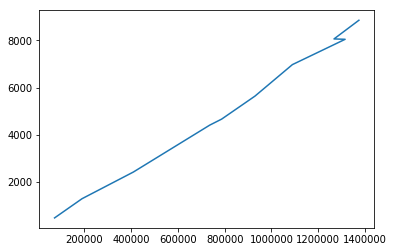

In [4]:
goodExamples = ["sym6_63","0410184","ex1","hwb4_52","parity"]
fileName=goodExamples[0]
#if testFromFile(filename) == 0:
fileName = testDir+fileName
bigFunction(fileName)